In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt

import pppc
from pppc.configs import PtychoNNTrainingConfigDict
from pppc.ptychonn.trainer import PtychoNNTrainer
from pppc.ptychonn.dataset_handle import HDF5Dataset
from pppc.ptychonn.model import PtychoNNModel, PtychoNNTransposedConvModel
from pppc.helper import transform_data_for_ptychonn

[2024-01-16 15:10:09,256] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-01-16 15:10:09,260] NumExpr defaulting to 8 threads.


Define some data transform functions for handling raw training data with different sizes. 

In [3]:
# Raw DP size 512, label 128; crop DPs to 384, then rescale to 128. (use default function in HDF5Dataset)
transform_func_512_128 = None
transform_func_kwargs_512_128 = None

# Raw DP size 512, label 128; crop DPs to 256, then pad to 384, and rescale to 128. (use default function in HDF5Dataset)
def transform_func_512_128_pad(dp):
    dp = transform_data_for_ptychonn(dp, target_shape=(256, 256), discard_len=(128, 128))
    dp = transform_data_for_ptychonn(dp, target_shape=(128, 128), discard_len=(-64, -64))
    return dp
transform_func_kwargs_512_128_pad = None

In [4]:
#decimate_ratio_list = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
decimate_ratio_list = [0.1]

for decimate_ratio in decimate_ratio_list:
    config_dict = PtychoNNTrainingConfigDict()
    
    config_dict['dataset_decimation_ratio'] = decimate_ratio
    
    config_dict['batch_size_per_process'] = 64
    config_dict['num_epochs'] = 60
    config_dict['learning_rate_per_process'] = 1e-4
    config_dict['optimizer'] = 'adam'
    config_dict['model_save_dir'] = '../../trained_models/model_36SpiralDatasets_dataDecimation_{}'.format(decimate_ratio)
    config_dict['validation_ratio'] = 0.1
    # Attention to transform_func and transform_func_kwargs. They must match the training data. 
    dataset = HDF5Dataset('data/data_train.h5', verbose=False, transform_func=transform_func_512_128, transform_func_kwargs=transform_func_kwargs_512_128)
    config_dict['dataset'] = dataset
    config_dict['model'] = (PtychoNNModel, {'n_levels': 4})
    config_dict['debug'] = False
    
    trainer = PtychoNNTrainer(config_dict)
    trainer.build(seed=196)
    
    trainer.run_training()

[2024-01-16 15:10:11,226] Decimating dataset to 0.1 of the original size...
[2024-01-16 15:10:11,429] Using DataParallel with 2 devices.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:29<00:00,  1.16s/it]
[2024-01-16 15:11:08,347] Saving improved model after Val Loss improved from inf to 0.65148
[2024-01-16 15:11:08,442] Epoch: 0 | FT  | Train Loss: 0.95007 | Val Loss: 0.65148
[2024-01-16 15:11:08,443] Epoch: 0 | Amp | Train Loss: 0.3334 | Val Loss: 0.0779
[2024-01-16 15:11:08,444] Epoch: 0 | Ph  | Train Loss: 0.617 | Val Loss: 0.574
[2024-01-16 15:11:08,445] Epoch: 0 | Ending LR: 0.000050 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.

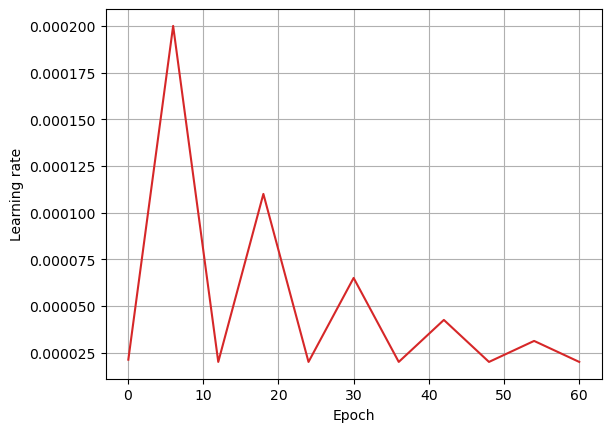

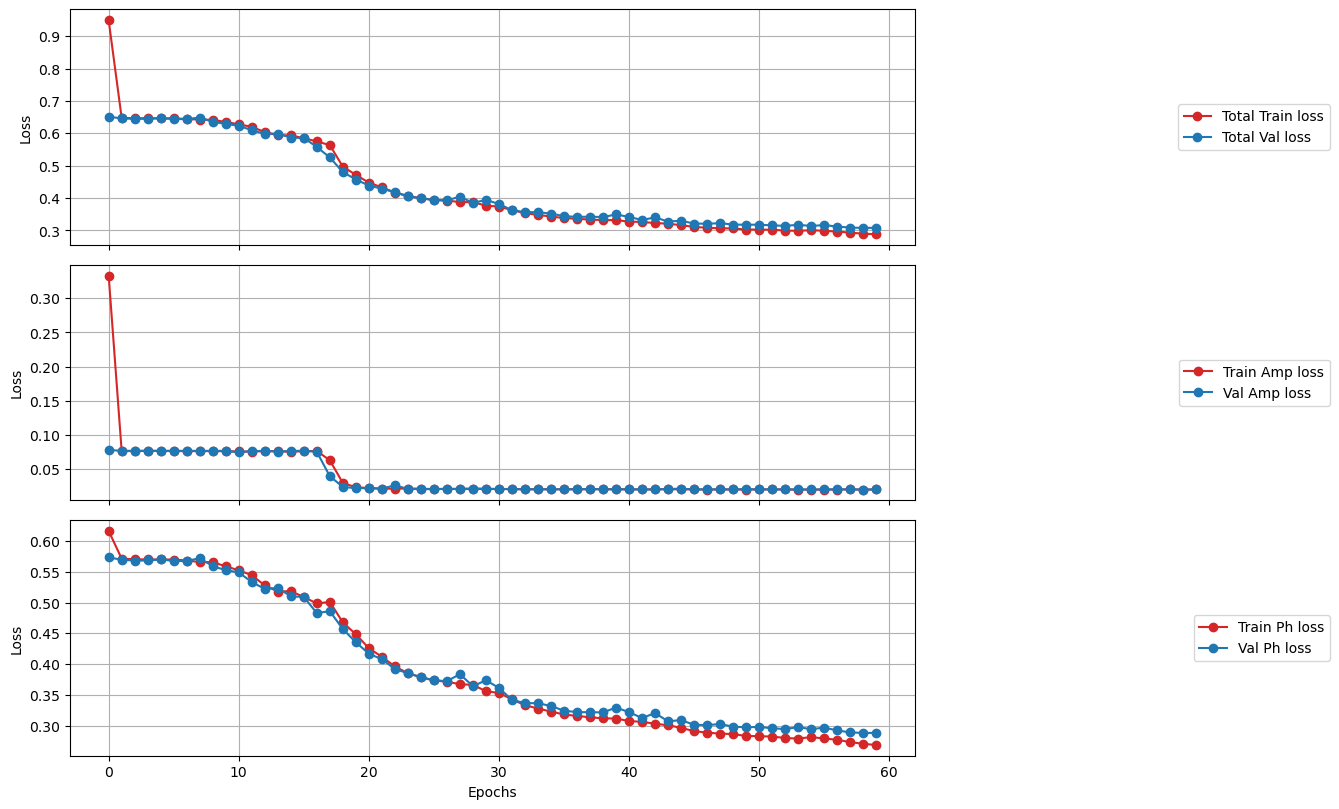

In [5]:
trainer.plot_training_history()